# Interpreting a model
----
A very important step in tuning a model and getting an understanding of what it is doing is the so-called model interpretability. I.e. understanding why a model makes specific decisions.

Captum is a package we can use to gain understanding of how various features and feature values atttributed to a decision of a Pytorch model. Captum has a wide variety of algorithms to choose from. This notebook will show some basic examples. 

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from typing import List, Tuple

from captum.attr import IntegratedGradients

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create our Dummy file w/Noise

If it wasn't totally clear before; most of this file is random, but the way we assign the **fraud** flag is not. If we want our model to learn something, the fraud flag can ofcourse not be random, our model would not understand what is going on if there was nothing about the other attributes that influences the fraud flag. See code snippet;

`Fraud = 1 if Country in ['FR', 'NL'] and amount > 100 and MCC in ['0001', '0002', '0003', '0010'] else 0`

We might rightfully assume that above logic should in some shape or form be visible in the feature attributions. For instance country 'FR' and 'NL' should normally have strong attributions for the fraud cases, as should amounts above 100 and some specific MCC codes.

Just so as to prove the point, this file also contains a **random number** the `Noise` feature that has no relation to the *fraud* label, another way of saying would be that they have no correlation. We might assume that the attribution of this feature would look differently than the other feature that clearly do attribute to the *fraud* label because they are used in the logic to set the label.

In [2]:
header = 'Date,Amount,Noise,Card,Merchant,MCC,Country,Fraud\n'
file = './data/bigger_card.csv'

MCC_LIST = [f'{i:04d}' for i in range(25)] # Create 25 MCC-Codes
MCC_PROB = list(np.random.random(len(MCC_LIST)))
MCC_PROB = [p/sum(MCC_PROB) for p in MCC_PROB]

Country_LIST = ['FR', 'DE', 'GB', 'NL', 'ES', 'IT', 'SE', 'PL', 'CH'] # Create 9 country codes
Country_PROB = list(np.random.random(len(Country_LIST)))
Country_PROB = [p/sum(Country_PROB) for p in Country_PROB]

number_of_records = 10000

with open(file, 'w') as f:
    f.write(header)
    for i in range(number_of_records):
        # Dates in range 1st till 30th of January, increasing.
        date = f'202001{int((i/(number_of_records/30))+1):02d}'
        # Random normally distributed amount. Mean 100, stddev 30. Rounded to 2 decimals.
        amount = np.around(np.random.normal(100, 30, 1), 2).item()
        # Create noise feature
        noise = np.around(np.random.random_sample(),2)
        # Create a random card nr 0 to 50
        card_nr = np.random.randint(50)
        # Select an MCC, draw from MCC List accoring to MCC_PROB probability distribution.
        MCC = np.random.choice(MCC_LIST, 1, p=MCC_PROB).item()
        # Select an MCC, draw from Country List accoring to County_PROB probability distribution.
        Country = np.random.choice(Country_LIST, 1, p=Country_PROB).item()
        # Assign some Fraud, this can not be random if we the model to learn something.
        Fraud = 1 if Country in ['FR', 'NL'] and amount > 100 and MCC in ['0001', '0002', '0003', '0010'] else 0
        # Make row and write.
        row = f'{date},{amount},{noise},CARD-{card_nr},MRC-{MCC},{MCC},{Country},{Fraud}\n'
        f.write(row)

Displaying the first 10 lines of our data-set

In [3]:
!head -10 $file

Date,Amount,Noise,Card,Merchant,MCC,Country,Fraud
20200101,54.98,0.24,CARD-1,MRC-0002,0002,NL,0
20200101,105.22,0.83,CARD-40,MRC-0024,0024,ES,0
20200101,157.77,0.61,CARD-46,MRC-0020,0020,CH,0
20200101,146.97,0.12,CARD-17,MRC-0000,0000,CH,0
20200101,108.83,0.29,CARD-12,MRC-0023,0023,NL,0
20200101,83.78,0.21,CARD-42,MRC-0020,0020,ES,0
20200101,127.66,0.24,CARD-33,MRC-0022,0022,NL,0
20200101,46.34,0.98,CARD-29,MRC-0009,0009,PL,0
20200101,104.89,0.57,CARD-26,MRC-0015,0015,GB,0


Let's also display the probabilities we used to generate the file. That will be useful to interpret the attribution outcomes.

In [4]:
# Country Probabilities 
for c, p in zip(Country_LIST , Country_PROB):
    print(f'{c}: {p:.02f}')

FR: 0.02
DE: 0.16
GB: 0.07
NL: 0.19
ES: 0.18
IT: 0.02
SE: 0.07
PL: 0.18
CH: 0.11


In [5]:
# MCC Probabilities
for c, p in zip(MCC_LIST , MCC_PROB):
    print(f'{c}: {p:.02f}')

0000: 0.07
0001: 0.03
0002: 0.09
0003: 0.00
0004: 0.02
0005: 0.01
0006: 0.04
0007: 0.01
0008: 0.00
0009: 0.06
0010: 0.02
0011: 0.01
0012: 0.07
0013: 0.02
0014: 0.07
0015: 0.05
0016: 0.05
0017: 0.05
0018: 0.01
0019: 0.02
0020: 0.07
0021: 0.07
0022: 0.09
0023: 0.03
0024: 0.05


## Create our features and data-set

In [6]:
amount  = ft.FeatureSource('Amount', ft.FEATURE_TYPE_FLOAT_32)
noise  = ft.FeatureSource('Noise', ft.FEATURE_TYPE_FLOAT_32)
mcc     = ft.FeatureSource('MCC', ft.FEATURE_TYPE_CATEGORICAL, default='0000')
country = ft.FeatureSource('Country', ft.FEATURE_TYPE_CATEGORICAL)
fraud   = ft.FeatureSource('Fraud', ft.FEATURE_TYPE_INT_8)

amount_scaled = ft.FeatureNormalizeScale('Scaled_Amount', ft.FEATURE_TYPE_FLOAT_32, amount)
mcc_oh        = ft.FeatureOneHot('MCC_OH', ft.FEATURE_TYPE_INT_8,  mcc)
country_oh    = ft.FeatureOneHot('Country_OH', ft.FEATURE_TYPE_INT_8, country)
fraud_label   = ft.FeatureLabelBinary('Fraud_Label', ft.FEATURE_TYPE_INT_8, fraud)

td_oh     = ft.TensorDefinition('Features_OH', [mcc_oh, country_oh])
td_amount = ft.TensorDefinition('Feature_Amount', [amount_scaled, noise])
td_label  = ft.TensorDefinition('Feature_Fraud', [fraud_label])


with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_amount, td_oh, td_label), file, inference=False)
    
train, val, test = ti.split_sequential(2000,1000)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

cpu        = torch.device('cpu')
batch_size = 32

train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(cpu, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(cpu, batch_size, num_workers=2)

2023-05-14 11:28:38.276 eng1n3.common.engine           INFO     Start Engine...
2023-05-14 11:28:38.277 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-14 11:28:38.278 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-14 11:28:38.279 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ./data/bigger_card.csv
2023-05-14 11:28:38.296 e...renormalizescaleprocessor  INFO     Create Scaled_Amount Scale Amount. Min. -12.77 Max. 210.64
2023-05-14 11:28:38.298 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-05-14 11:28:38.299 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays


## One Hot Model

Create our model, same old.

In [7]:
class FirstModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(FirstModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        head_size = sum([h.output_size for h in self.heads])
        
        # And a tail layer, for a binary classifier this is a Linear Layer + a Sigmoid Activation.
        self.tail = self.create_tail(head_size)

    # Create a forward-pass function through the neural net. Make sure to return a TUPLE of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.tail(o)
        return (o,)

#Create a 'FirstModel' instance
model = FirstModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

FirstModel(
  Number of parameters : 37. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
    (1): TensorDefinitionHead(Name=Features_OH, lc=Binary)
  )
  (tail): Sequential(
    (tail_lin): Linear(in_features=36, out_features=1, bias=True)
    (tail_sig): Sigmoid()
  )
)

## Train our model
Train the model and plot the training history.

In [8]:
# First create a trainer.
trainer = mp.Trainer(model, torch.device('cpu'), train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=0.1)
# Run the trainer for 5 epochs
history = trainer.train(5, optimizer)

Epoch 005/005: 100%|██████████| 282/282 [00:00<00:00, 1051.13it/s, t_loss=0.0325, t_acc=0.993, v_loss=0.0525, v_acc=0.982]     


## Call captum
Captum has a wide variety of algorithms to calculate the attribution of features, see the documentation for more info; [Captum APi](https://captum.ai/api/). The m0d3l package has a helper function that takes care of the tricky bit. And it is a bit tricky, embeddings need to be handled specifically, you need a specific forward function because captum unpacks the tuples of tensors you feed as input, etc...

Long story short, it is possible to run attribution algorithms that have a signature `class
captum.attr.<captum_algo>(forward_func)`. If the captum algorithm takes other input, then you'll need to write a custom funtion.

Below cell gets the Attributions for our `model` instance, using the `IntegratedGradients` attribution algorithm and it uses the first `1000 records of the test data-set`

In [9]:
attr = cp.CaptumAttributions.get_attributions_binary(
    model, ti.target_tensor_def, torch.device('cpu'), IntegratedGradients, test_ds[0:1000]
)

Once we have the attributions we can call various plot functions.

The first one is a violin plot of attributions of each input feature. Violin plots don't only show the minimum and maximum attributions, but also give an idea of the probability density distribution. In areas where the violin gets broader, we have more occurences of a given attribution value, hence a higher probability.

Mostly when you run this, you'll see something like below. 
- The amount attribution starts at 0, it never gets negative.
- Both OH features seen to mostly attribute negatively, but there are occasions where attribute a lot (most likely for the values we set in the fraud condition).
- The noise feature has a very flat distribution it seem to main attribute very low values. Though it does seem to contribute negative values in some case, we can see t his from the whisker pointing down to about -0.09.

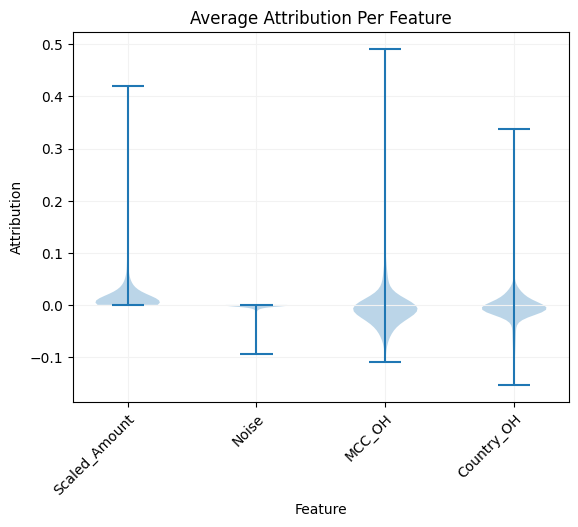

In [10]:
mplt.AttributionPlotBinary.overview(attr)

It is also possible to get the detail of a specific feature. For continous features a scatter plot is quite informative, it plots the values of the feature on the X-axis and the attribution on the Y-axis. The points are color coded according to the classification label.

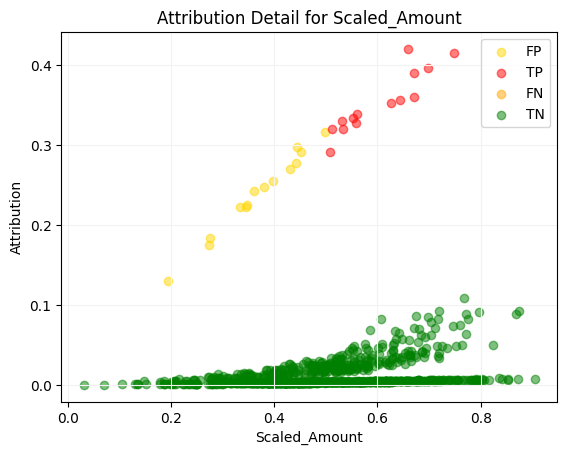

In [11]:
mplt.AttributionPlotBinary.feature_detail(attr, amount_scaled)

For categorical values the detail shows the **average** contribution per value in the sample.

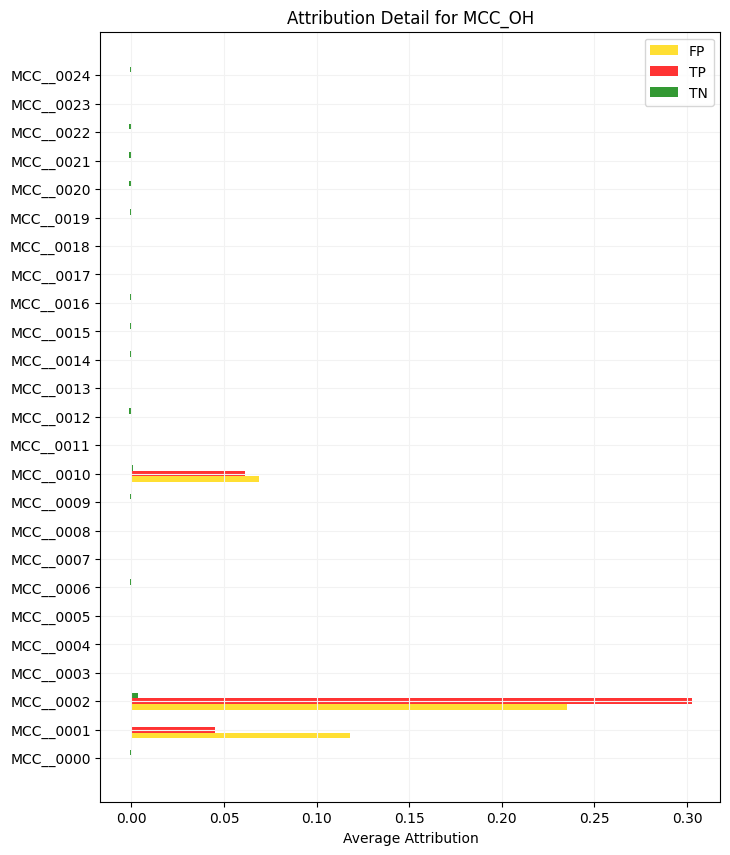

In [12]:
mplt.AttributionPlotBinary.feature_detail(attr, mcc_oh, fig_size=(8,10))

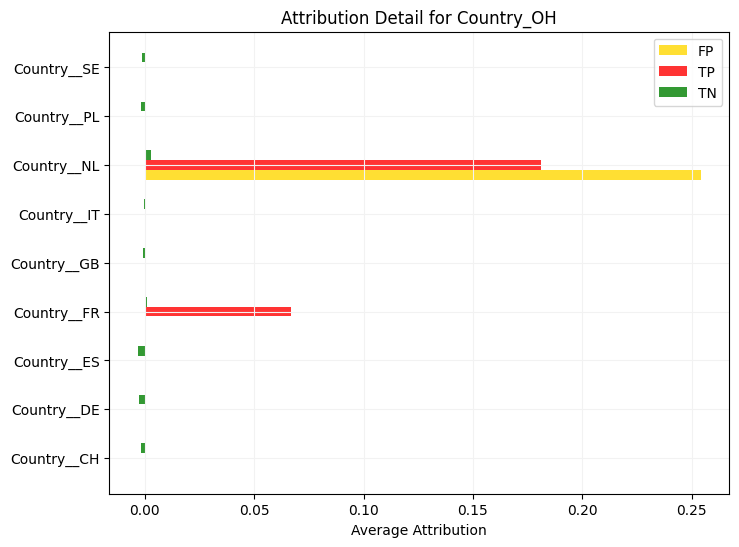

In [13]:
mplt.AttributionPlotBinary.feature_detail(attr, country_oh, fig_size=(8,6))

In the detail plot of the Noise value, we see that the model has not quite figured out that the noise does not contribute, it looks like it thinks the noise reduces the probability of fraud for the actual fraud cases. But overall the scale of these values is lower than the other features.

It is quite informative to see what happens to this as you keep on training the model, this plot starts out a bit like the inverse of the Scaled_Amount, but the more you train the more the plot converges to a flat line near 0.

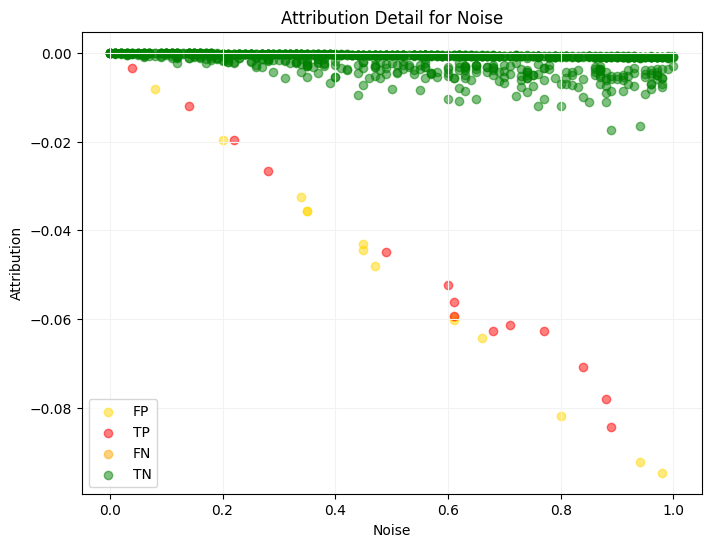

In [14]:
mplt.AttributionPlotBinary.feature_detail(attr, noise, fig_size=(8,6))

It is also possible to show the contributions on a heatmap. The heatmap show the original value of the data in the text and the color depth indicates the attribution. The color of the text show the classification result. It indicates if the sample was True Positive, False Positive, False Negative or True Negative.

We'll make the sample slightly smaller for this test.

In [15]:
attr = cp.CaptumAttributions.get_attributions_binary(
    model, ti.target_tensor_def, torch.device('cpu'), IntegratedGradients, test_ds[0:20]
)

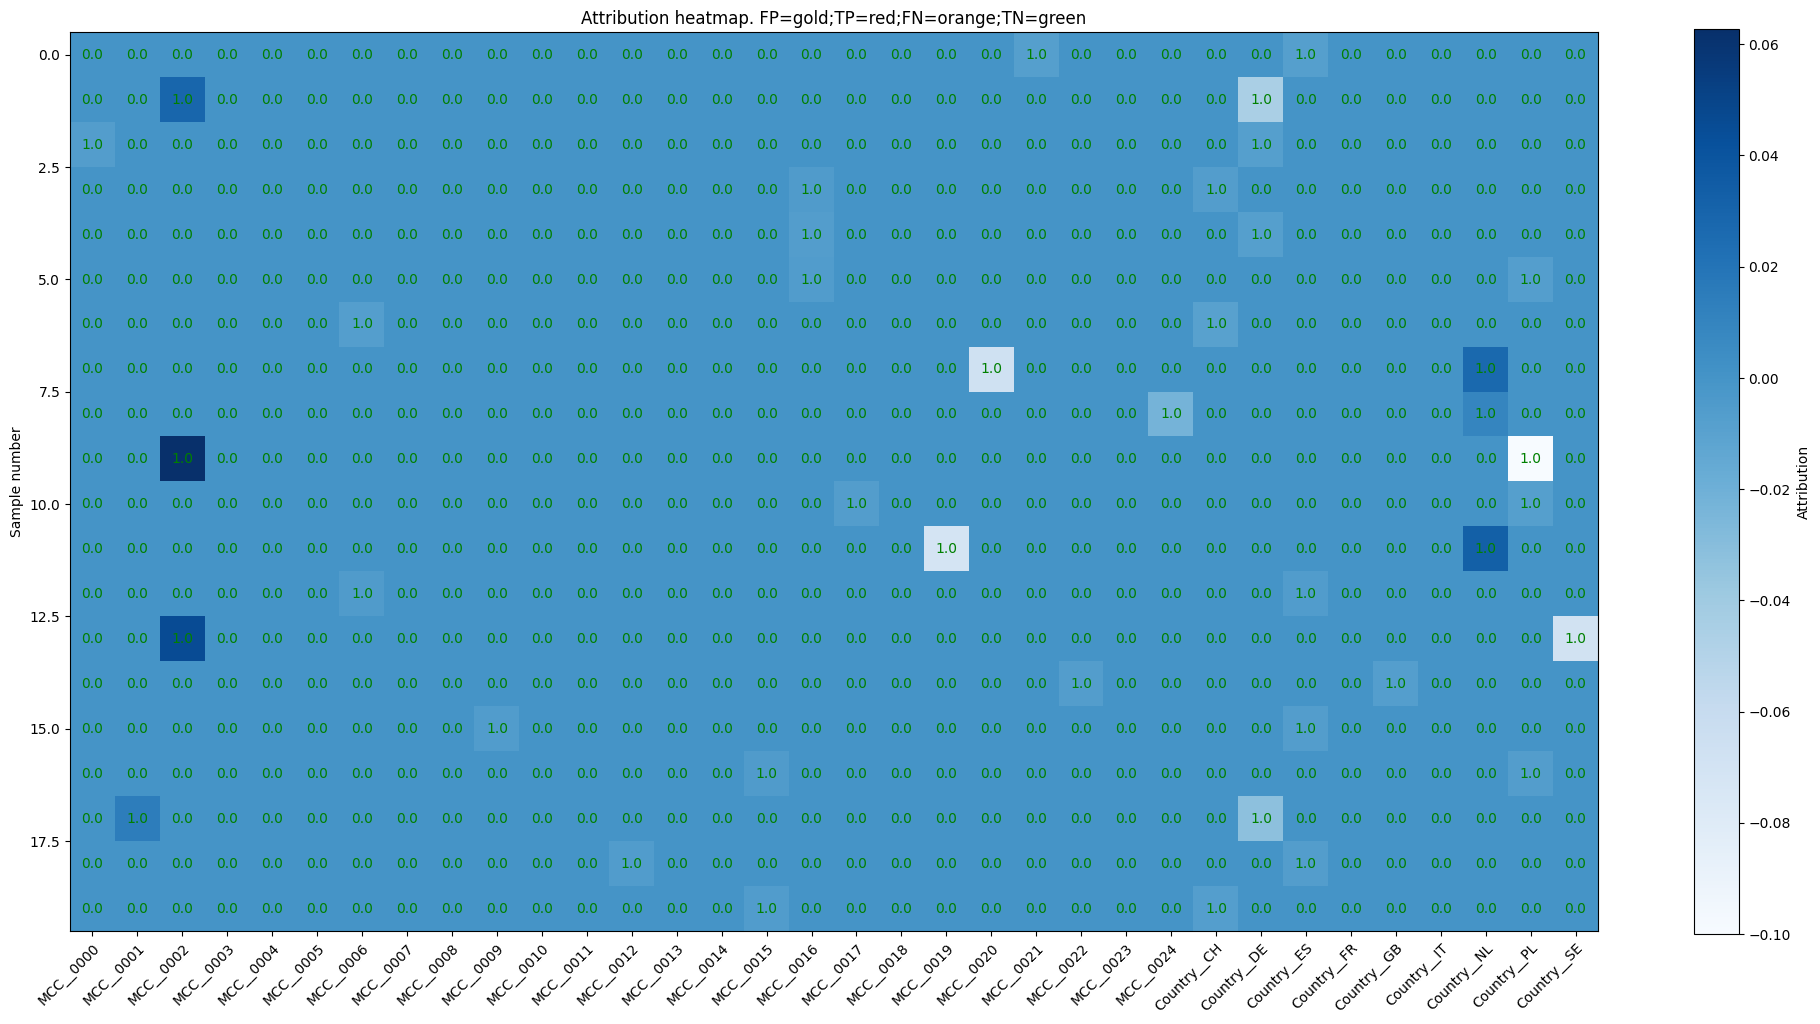

In [16]:
mplt.AttributionPlotBinary.heatmap(attr, td_oh, fig_size=(20,10), font_size=10)

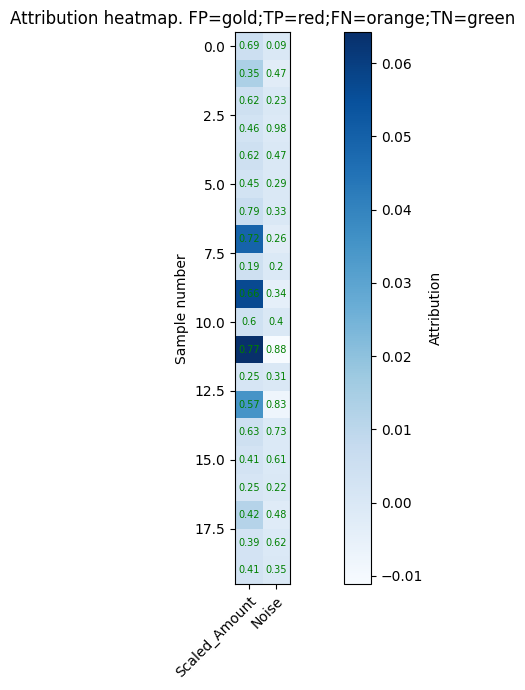

In [17]:
mplt.AttributionPlotBinary.heatmap(attr, td_amount, fig_size=(11,7), font_size=7)

## We can also try this for models that have embeddings.

Here the Country and MCC features are changed so they become `FeatureIndex` instead of `FeatureOneHot`

In [18]:
amount  = ft.FeatureSource('Amount', ft.FEATURE_TYPE_FLOAT_32)
noise  = ft.FeatureSource('Noise', ft.FEATURE_TYPE_FLOAT_32)
mcc     = ft.FeatureSource('MCC', ft.FEATURE_TYPE_CATEGORICAL, default='0000')
country = ft.FeatureSource('Country', ft.FEATURE_TYPE_CATEGORICAL)
fraud   = ft.FeatureSource('Fraud', ft.FEATURE_TYPE_INT_8)

amount_scaled = ft.FeatureNormalizeScale('Scaled_Amount', ft.FEATURE_TYPE_FLOAT_32, amount)
mcc_i         = ft.FeatureIndex('MCC_I', ft.FEATURE_TYPE_INT_16,  mcc)
country_i     = ft.FeatureIndex('Country_I', ft.FEATURE_TYPE_INT_16, country)
fraud_label   = ft.FeatureLabelBinary('Fraud_Label', ft.FEATURE_TYPE_INT_8, fraud)

td_i      = ft.TensorDefinition('Features_I', [mcc_i, country_i])
td_amount = ft.TensorDefinition('Feature_Amount', [amount_scaled, noise])
td_label  = ft.TensorDefinition('Feature_Fraud', [fraud_label])


with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_amount, td_i, td_label), file, inference=False)
    
train, val, test = ti.split_sequential(2000,1000)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

cpu        = torch.device('cpu')
batch_size = 32

train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(cpu, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(cpu, batch_size, num_workers=2)

2023-05-14 11:29:45.148 eng1n3.common.engine           INFO     Start Engine...
2023-05-14 11:29:45.149 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-14 11:29:45.149 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-14 11:29:45.149 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ./data/bigger_card.csv
2023-05-14 11:29:45.158 e...renormalizescaleprocessor  INFO     Create Scaled_Amount Scale Amount. Min. -12.77 Max. 210.64
2023-05-14 11:29:45.159 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-05-14 11:29:45.160 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays


## The same as the previous Model, but with Embeddings

In [20]:
class SecondModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(SecondModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads(dim_ratio=0.6, min_dims=2, max_dims=5, dropout=0.1)
        head_size = sum([h.output_size for h in self.heads])
        
        # And a tail layer, for a binary classifier this is a Linear Layer + Sigmoid Acivation.
        self.tail = self.create_tail(head_size)

    # Create a forward-pass function through the neural net. Make sure to return a TUPLE of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.tail(o)
        return (o,)

#Create a 'SecondModel' instance
model = SecondModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

SecondModel(
  Number of parameters : 193. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
    (1): TensorDefinitionHead(
      Name=Features_I, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(26, 5)
          (1): Embedding(10, 5)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (tail): Sequential(
    (tail_lin): Linear(in_features=12, out_features=1, bias=True)
    (tail_sig): Sigmoid()
  )
)

## Train our model
Train the model and plot the training history. We're going to use a slightly lower learning rate because this model has a bit more parameters. This way of setting the learning rate is very much hand-wavy, at present, but at a learning rate of 0.1 the results seem to vary a lot.

In [21]:
# First create a trainer.
trainer = mp.Trainer(model, torch.device('cpu'), train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=0.05)
# Run the trainer for 5 epochs
history = trainer.train(5, optimizer)

Epoch 005/005: 100%|██████████| 282/282 [00:00<00:00, 884.98it/s, t_loss=0.0336, t_acc=0.994, v_loss=0.0654, v_acc=0.982]      


## Call Captum
We're not going to go into too much of the detail, but Captum needs the embedding weights as input, not the indexes. The entire embedding need to be wrapped in a `InterpretableEmbeddingBase` object. Luckily the `get_attributions_binary` does this for us.

Below line will show a warning, which can be ignored, `get_attributions_binary` will also restore the original embedding.

In [22]:
attr = cp.CaptumAttributions.get_attributions_binary(
    model, ti.target_tensor_def, torch.device('cpu'), IntegratedGradients, test_ds[0:1000])

/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


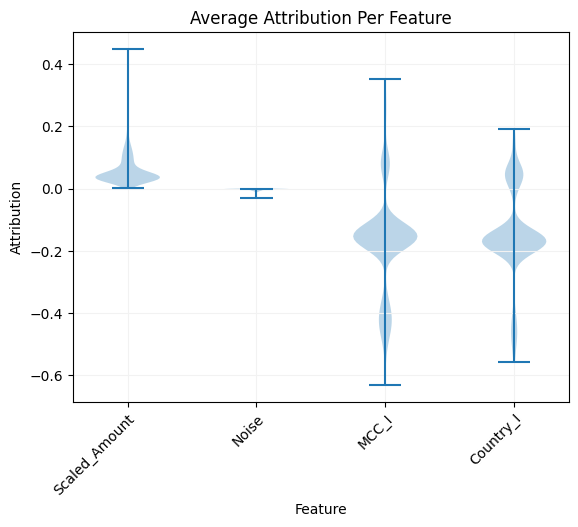

In [23]:
mplt.AttributionPlotBinary.overview(attr)

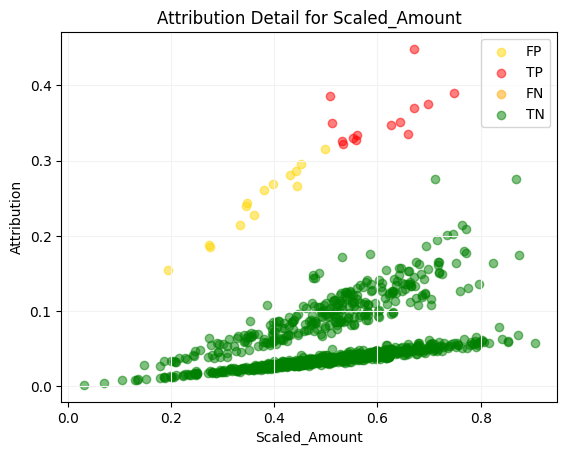

In [24]:
mplt.AttributionPlotBinary.feature_detail(attr, amount_scaled)

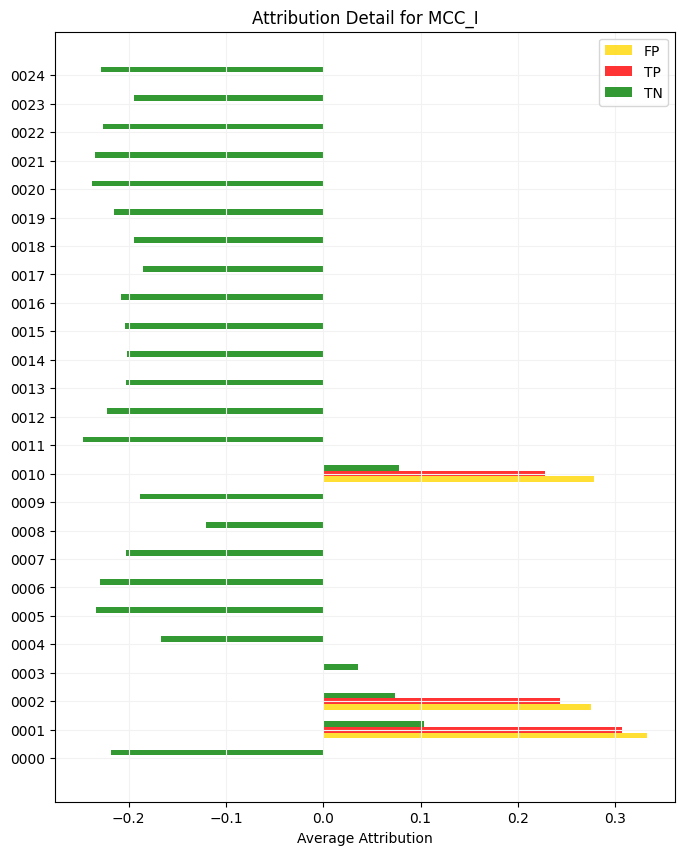

In [25]:
mplt.AttributionPlotBinary.feature_detail(attr, mcc_i, fig_size=(8,10))

We can also visualize the embeddings, in our case they have more than 3 dimensions, so we can't really visualize them. One thing we can do is reduce the number of dimensions to 2 or 3, in this case with PCA (Principle Component Analysis) and then plot.

PCA will reduce the number of dimension to axis where there is most variance in the space (the space is streched out most) and where these axis are orthogonal.

An embedding plot will have the explained variance in the header. It should always be taken into consideration. If the first component has a really high explained variance, then the space is really streched out far across that axis.

In models as simple as this on problems as simple as our one rule, you'll often find that the fraud attributes are on one side of the space on an axis that explains a lot of variance. **But note; the location in the space does not have to be linked to the fraud label, it may represent other aspects of the data**

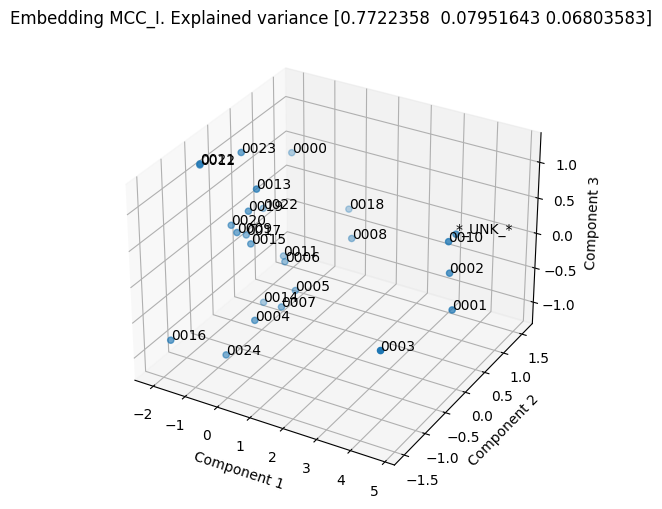

In [26]:
mcc_weights = model.heads[1].embedding.embedding_weight(mcc_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(mcc_i, mcc_weights, dims=3, fig_size=(6,6))

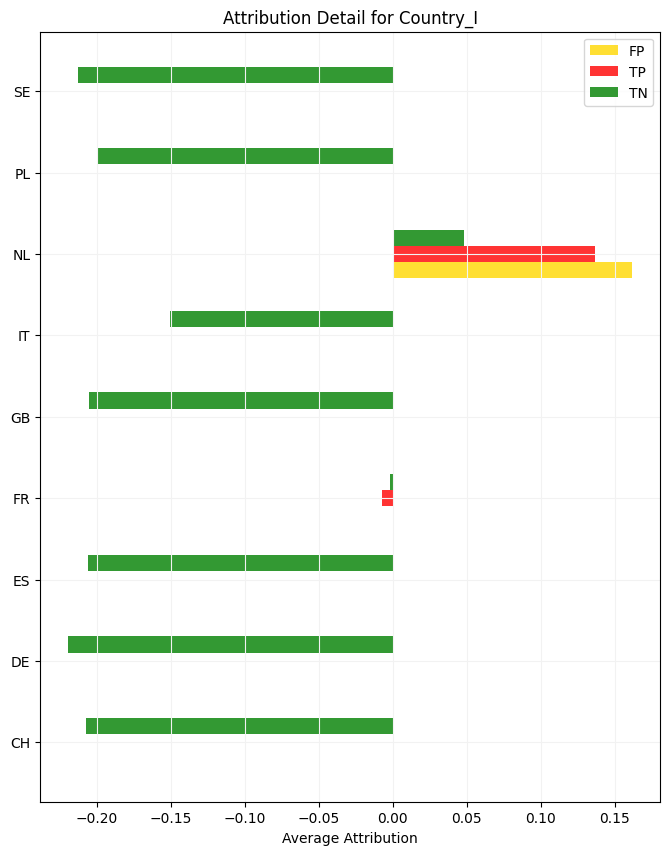

In [27]:
mplt.AttributionPlotBinary.feature_detail(attr, country_i, fig_size=(8,10))

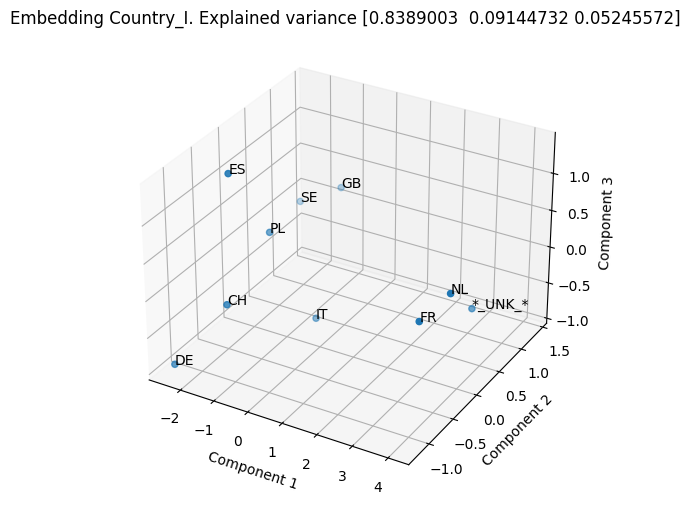

In [28]:
country_weights = model.heads[1].embedding.embedding_weight(country_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(country_i, country_weights, dims=3, fig_size=(6,6))

In [29]:
attr = cp.CaptumAttributions.get_attributions_binary(
    model, ti.target_tensor_def, torch.device('cpu'), IntegratedGradients, test_ds[0:20]
)

/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


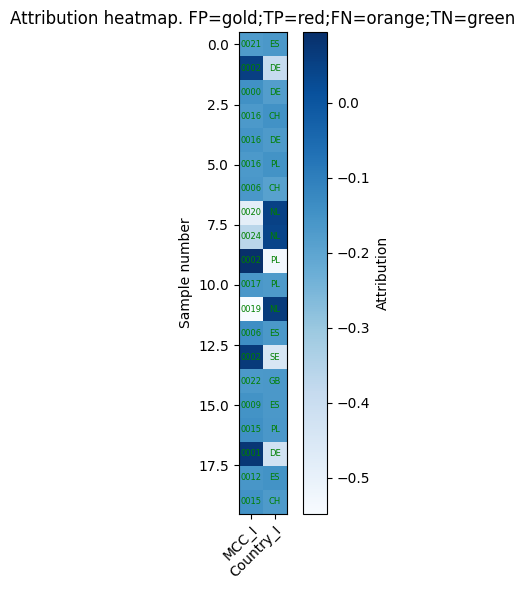

In [30]:
mplt.AttributionPlotBinary.heatmap(attr, td_i, fig_size=(4,6), font_size=6)

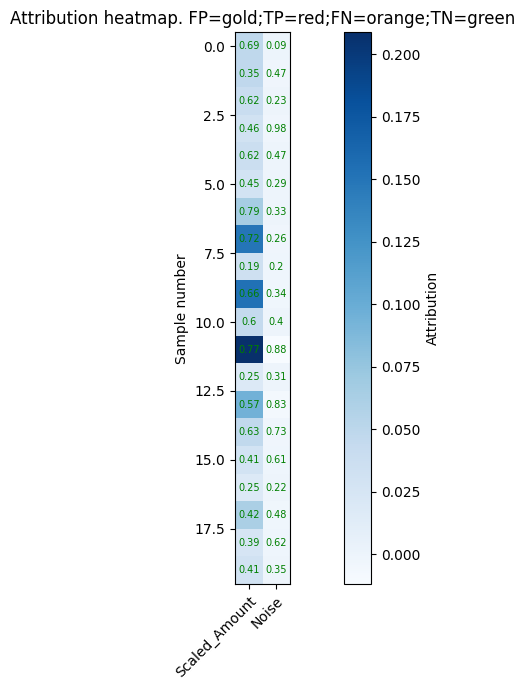

In [31]:
mplt.AttributionPlotBinary.heatmap(attr, td_amount, fig_size=(11,7), font_size=7)

Clean-up after ourselves. Delete our test file.

In [32]:
!rm $file

## Conslusion

By now we know how to get a bit of insight into how various features attribute to the decision of our models. This should be useful in further research.

We might also be tempted to think that the same model seem to behave differently when we use FeatureIndex vs FeatureOneHot. The models clearly react differently, but note that the embedding model has about 5 times more parameters as compared to the 'OneHot' model (193 vs 37). And overall these models are really simple. The OneHot model has one layer only, so more or less does logistic regression. So it's a bit early to start drawing conclusions.